# 1. Loading Data

In [1]:
import sys
import gc
import os
import warnings
import pickle
import statsmodels.api as sm
from pylab import rcParams
import time
from  datetime import datetime, timedelta

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

register_matplotlib_converters()
sns.set()

/usr/local/anaconda3/envs/data_science/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


## 1.1 Functions

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def display_missing(df):    
    for col in df.columns.tolist():  
        if df[col].isnull().sum() != 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    


## 1.2 Loading data grid

In [3]:
DATA_GRID_INPUT_DIR = '.'

In [4]:
print('Loading the data...')

data = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_model2.pkl')

Loading the data...


## 1.3 Init variables

In [5]:
h = 28 # Prediction horizon
max_lags = 120 # Max lags used
TRAINING_LAST_DAY_NUM = 1913 # Last day for training data
FIRST_PRED_DAY = datetime(2016,4, 25) # First prediction day
FIRST_LOADING_DAY = datetime(2013, 4,7) # First day for training
FIRST_LOADING_DAY_NUM = 800
SEED = 7


In [6]:
#data = data.loc[data.date>'2015-01-01']

# 2. Feature Engineering

## Creating features


In [7]:
# Init global variable to store columns of encodings
# To use them later for test dataset

# target_enc_cols = []

In [8]:
def create_features(df):
    lags = [7, 28, 56]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)

    wins = [7, 28, 56]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype(np.float16)
            df[f"rmedian_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).median()).astype(np.float16)
            #df[f"rdiff_mean_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).diff().mean()).astype(np.float16)
            df[f"rstd_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).std()).astype(np.float16)
            df[f'rmean_{lag}_{win}_decay'] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x: x.ewm(span=win).mean()).astype(np.float16)

            #weights = np.power(0.9, np.arange(win)[::-1])
#             df[f'rmean_{lag}_{win}_decay'] = df[["id", lag_col]].groupby("id")[lag_col]\
#             .transform(lambda x : x.rolling(win).apply(lambda x: np.sum(weights*x))).astype(np.float32)

    
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
        
    
    # Adding mean/std target encoding features

    # Columns for to encode
#     icols =  [
#             ['state_id'],
#             ['store_id'],
#             ['cat_id'],
#             ['dept_id'],
#             ['state_id', 'cat_id'],
#             ['state_id', 'dept_id'],
#             ['store_id', 'cat_id'],
#             ['store_id', 'dept_id'],
#             ['item_id'],
#             ['item_id', 'state_id'],
#             ['item_id', 'store_id']
#             ]

#     global target_enc_cols 
    
#     for col in icols:
#         print('Encoding', col)
#         # TODO: Make this with variable, or may be use d column as integer
#         temp_df = df[df['date'] < datetime(2016, 3, 28)] # to be sure we don't have leakage in our validation set

#         temp_df = temp_df.groupby(col).agg({'sales': ['std','mean']})
#         col_name = '_enc_'+'_'.join(col)+'_'
#         new_columns = [col_name.join(col).strip() for col in temp_df.columns.values]
#         temp_df.columns = new_columns
#         temp_df = temp_df.reset_index()
#         #print(temp_df)
#         df = df.merge(temp_df, on=col, how='left')
#         #print(df)
#         # Save columns for later usage
#         target_enc_cols += new_columns
#         del temp_df
#         gc.collect()
    
    date_features = {
        
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     df.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(df["date"].dt, date_feat_func).astype("int16")
            
    
    return df
    

In [9]:
%%time

data = create_features(data)

CPU times: user 21min 3s, sys: 1min 1s, total: 22min 4s
Wall time: 22min 9s


In [10]:
# Choose one day from data set, to have
# all encodings for every id for later merge 
# with test data

# mean_encodings_df = data.loc[data['d'] == 'd_1913', ['id'] + target_enc_cols].copy()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 66 columns):
 #   Column              Dtype         
---  ------              -----         
 0   id                  object        
 1   item_id             int16         
 2   dept_id             int8          
 3   store_id            int8          
 4   cat_id              int8          
 5   state_id            int8          
 6   d                   object        
 7   sales               float16       
 8   date                datetime64[ns]
 9   wm_yr_wk            int16         
 10  weekday             int8          
 11  wday                int16         
 12  month               int16         
 13  year                int16         
 14  event_name_1        int8          
 15  event_type_1        int8          
 16  event_name_2        int8          
 17  event_type_2        int8          
 18  snap_CA             float16       
 19  snap_TX             float16       
 20  

In [12]:
data.dropna(inplace = True)
data.shape

(42644016, 66)

In [13]:
data

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,lag_t56,rmean_7_7,rmedian_7_7,rstd_7_7,rmean_7_7_decay,rmean_28_7,rmedian_28_7,rstd_28_7,rmean_28_7_decay,rmean_56_7,rmedian_56_7,rstd_56_7,rmean_56_7_decay,rmean_7_28,rmedian_7_28,rstd_7_28,rmean_7_28_decay,rmean_28_28,rmedian_28_28,rstd_28_28,rmean_28_28_decay,rmean_56_28,rmedian_56_28,rstd_56_28,rmean_56_28_decay,rmean_7_56,rmedian_7_56,rstd_7_56,rmean_7_56_decay,rmean_28_56,rmedian_28_56,rstd_28_56,rmean_28_56_decay,rmean_56_56,rmedian_56_56,rstd_56_56,rmean_56_56_decay,price_mean_t60,price_momentum_t60,woy,quarter,mday
1421629,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_112,0.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,4.570312,0.0,10.062500,4.437500,4.000000,0.0,8.585938,4.144531,0.000000,0.0,5.960464e-08,0.092163,5.179688,0.0,7.589844,4.750000,3.427734,0.0,6.390625,3.443359,0.643066,0.0,2.376953,0.921875,3.802734,0.0,6.570312,4.234375,2.035156,0.0,4.980469,2.960938,2.589844,0.0,4.527344,1.563477,0.466553,1.071289,20,2,20
1421636,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_112,0.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,1.769531,8.0,2.0,0.0,2.000000,1.0,3.000000,3.101562,3.000000,2.0,2.886719,2.400391,2.285156,1.0,3.251953e+00,1.721680,2.250000,1.0,2.703125,2.062500,1.713867,1.0,1.997070,2.044922,2.214844,1.0,2.986328,2.066406,1.892578,1.0,2.394531,1.990234,1.963867,1.0,2.529297,1.964844,2.197266,1.0,2.611328,2.125000,1.769531,1.000000,20,2,20
1421643,HOBBIES_1_010_CA_1_validation,9,0,0,0,0,d_112,0.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,3.169922,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000034,0.000000,0.0,0.000000,0.000747,0.000000,0.0,0.000000,0.003355,0.000000,0.0,0.000000,0.025208,0.000000,0.0,0.000000,0.008980,0.000000,0.0,0.000000,0.019531,0.107117,0.0,0.412354,0.058350,3.169922,1.000000,20,2,20
1421650,HOBBIES_1_012_CA_1_validation,11,0,0,0,0,d_112,0.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,6.269531,2.0,0.0,1.0,0.571289,0.0,0.976074,0.735352,0.571289,0.0,0.786621,0.434082,0.571289,0.0,7.866211e-01,0.471191,0.535645,0.0,0.744629,0.578125,0.678711,0.0,0.904785,0.601074,0.464355,0.0,0.744629,0.515625,0.606934,0.0,0.824219,0.578125,0.571289,0.0,0.828125,0.615234,0.571289,0.0,0.871094,0.542969,6.269531,1.000000,20,2,20
1421657,HOBBIES_1_015_CA_1_validation,14,0,0,0,0,d_112,3.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,0.680176,0.0,2.0,1.0,3.285156,0.0,5.312500,4.296875,2.000000,2.0,2.308594,2.093750,3.714844,1.0,4.425781e+00,2.802734,4.570312,1.5,6.800781,5.031250,4.820312,3.0,5.652344,4.121094,5.070312,2.5,5.542969,4.347656,4.910156,2.5,6.253906,4.992188,4.945312,3.0,5.546875,4.539062,4.695312,2.0,6.031250,4.667969,0.706055,0.963379,20,2,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46027952,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.980469,0.0,1.0,0.0,1.000000,0.0,1.527344,0.835938,0.714355,0.0,0.951172,0.732422,0.428467,0.0,7.866211e-01,0.499023,0.928711,0.5,1.184570,1.013672,1.250000,1.0,0.927734,0.956543,0.643066,0.5,0.730957,0.588867,1.053711,1.0,1.069336,0.988281,0.946289,1.0,0.882324,0.948242,0.714355,0.0,0.908691,0.640137,3.980469,1.000000,16,2,24
46027953,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.280273,0.0,2.0,0.0,0.856934,0.0,1.214844,0.725586,1.142578,1.0,0.689941,1.292969,0.000000,0.0,5.960464e-08,0.147583,1.036133,1.0,1.071289,0.952148,1.107422,1.0,0.956055,1.083984,1.000000,0.5,1.216797,0.780273,0.928711,1.0,1.041992,1.018555,1.053711,1.0,1.085938,1.090820,1.250

## Reduce mem usage of created features

In [14]:
data = reduce_mem_usage(data)

Mem. usage decreased to 5856.26 Mb (3.4% reduction)


In [15]:
gc.collect()

20

# 3. Fit & Predict

In [16]:
print('Data usage: {} GB'.format(data.memory_usage().sum() / 10**9))
data.head()

Data usage: 6.140738304 GB


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,lag_t56,rmean_7_7,rmedian_7_7,rstd_7_7,rmean_7_7_decay,rmean_28_7,rmedian_28_7,rstd_28_7,rmean_28_7_decay,rmean_56_7,rmedian_56_7,rstd_56_7,rmean_56_7_decay,rmean_7_28,rmedian_7_28,rstd_7_28,rmean_7_28_decay,rmean_28_28,rmedian_28_28,rstd_28_28,rmean_28_28_decay,rmean_56_28,rmedian_56_28,rstd_56_28,rmean_56_28_decay,rmean_7_56,rmedian_7_56,rstd_7_56,rmean_7_56_decay,rmean_28_56,rmedian_28_56,rstd_28_56,rmean_28_56_decay,rmean_56_56,rmedian_56_56,rstd_56_56,rmean_56_56_decay,price_mean_t60,price_momentum_t60,woy,quarter,mday
1421629,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_112,0.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,4.570312,0.0,10.062500,4.437500,4.000000,0.0,8.585938,4.144531,0.000000,0.0,5.960464e-08,0.092163,5.179688,0.0,7.589844,4.750000,3.427734,0.0,6.390625,3.443359,0.643066,0.0,2.376953,0.921875,3.802734,0.0,6.570312,4.234375,2.035156,0.0,4.980469,2.960938,2.589844,0.0,4.527344,1.563477,0.466553,1.071289,20,2,20
1421636,HOBBIES_1_009_CA_1_validation,8,0,0,0,0,d_112,0.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,1.769531,8.0,2.0,0.0,2.000000,1.0,3.000000,3.101562,3.000000,2.0,2.886719,2.400391,2.285156,1.0,3.251953e+00,1.721680,2.250000,1.0,2.703125,2.062500,1.713867,1.0,1.997070,2.044922,2.214844,1.0,2.986328,2.066406,1.892578,1.0,2.394531,1.990234,1.963867,1.0,2.529297,1.964844,2.197266,1.0,2.611328,2.125000,1.769531,1.000000,20,2,20
1421643,HOBBIES_1_010_CA_1_validation,9,0,0,0,0,d_112,0.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,3.169922,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000034,0.000000,0.0,0.000000,0.000747,0.000000,0.0,0.000000,0.003355,0.000000,0.0,0.000000,0.025208,0.000000,0.0,0.000000,0.008980,0.000000,0.0,0.000000,0.019531,0.107117,0.0,0.412354,0.058350,3.169922,1.000000,20,2,20
1421650,HOBBIES_1_012_CA_1_validation,11,0,0,0,0,d_112,0.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,6.269531,2.0,0.0,1.0,0.571289,0.0,0.976074,0.735352,0.571289,0.0,0.786621,0.434082,0.571289,0.0,7.866211e-01,0.471191,0.535645,0.0,0.744629,0.578125,0.678711,0.0,0.904785,0.601074,0.464355,0.0,0.744629,0.515625,0.606934,0.0,0.824219,0.578125,0.571289,0.0,0.828125,0.615234,0.571289,0.0,0.871094,0.542969,6.269531,1.000000,20,2,20
1421657,HOBBIES_1_015_CA_1_validation,14,0,0,0,0,d_112,3.0,2011-05-20,11116,0,7,5,2011,0,0,0,0,0.0,0.0,0.0,0.680176,0.0,2.0,1.0,3.285156,0.0,5.312500,4.296875,2.000000,2.0,2.308594,2.093750,3.714844,1.0,4.425781e+00,2.802734,4.570312,1.5,6.800781,5.031250,4.820312,3.0,5.652344,4.121094,5.070312,2.5,5.542969,4.347656,4.910156,2.5,6.253906,4.992188,4.945312,3.0,5.546875,4.539062,4.695312,2.0,6.031250,4.667969,0.706055,0.963379,20,2,20


In [17]:
# train_end_dt = datetime(2016, 3, 27)
# valid_end_dt = datetime(2016, 4, 24)

valid_start = datetime(2016, 3, 28)
train_valid_end_dt = datetime(2016, 4, 27)

In [18]:
%%time

cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday", "weights"]
train_cols = data.columns[~data.columns.isin(useless_cols)]
#used_cols = train_cols.append(pd.Index(['weights'])) # with weights

# Splitting train and validation by date (28 days before prediction horizon)
# To drop na values only from training set
# train = data.loc[data.date <= train_end_dt].dropna()
X_train = data[train_cols]
y_train = data["sales"]

X_valid= data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), train_cols]
y_valid = data.loc[(data.date >= valid_start) & (data.date <= train_valid_end_dt), "sales"]
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=cat_feats, free_raw_data=False)
# train_data = lgb.Dataset(X_train[train_cols], label = y_train, weight=X_train['weights'], categorical_feature=cat_feats, free_raw_data=False)
# valid_data = lgb.Dataset(X_valid[train_cols], label = y_valid, weight=X_valid['weights'], categorical_feature=cat_feats, free_raw_data=False)


# Random train-validation split
# X_train = data[used_cols]
# y_train = data["sales"]

# np.random.seed(SEED)
# valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
# train_inds = np.setdiff1d(X_train.index.values, valid_inds)

# train_data = lgb.Dataset(X_train.loc[train_inds, train_cols] ,\
#                          label = y_train.loc[train_inds], weight=X_train.loc[train_inds, "weights"],\
#                          categorical_feature=cat_feats, free_raw_data=False)
# valid_data = lgb.Dataset(X_train.loc[valid_inds, train_cols], \
#                          label = y_train.loc[valid_inds], weight=X_train.loc[valid_inds, "weights"],\
#                          categorical_feature=cat_feats, free_raw_data=False)
# del valid_inds, train_inds

del data, X_train, y_train 

gc.collect()


CPU times: user 3.41 s, sys: 2.14 s, total: 5.55 s
Wall time: 5.63 s


0

In [19]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'subsample': 0.5,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'num_leaves': 2**11-1,
            'min_data_in_leaf': 2**12-1,
            'feature_fraction': 0.5,
            'max_bin': 100,
            'n_estimators': 1400,
            'boost_from_average': False,
            'verbose': 1,
            'seed': SEED,
} 

# params = {
#         "objective" : "poisson",
#         "metric" :"rmse",
#         "force_row_wise" : True,
#         "learning_rate" : 0.075,
# #         "sub_feature" : 0.8,
#         "sub_row" : 0.8,
#         "bagging_freq" : 1,
#         'feature_fraction': 0.8,
#         "lambda_l2" : 0.1,
# #         "nthread" : 4
#         'verbosity': 1,
#         'num_iterations' : 1200,
#         'num_leaves': 2**7-1,
#         "min_data_in_leaf": 2**7-1,
#         'early_stopping_rounds': 125,
#         'seed': SEED,
# }

In [20]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], 
                  verbose_eval=50)


[50]	training's rmse: 2.73702	valid_1's rmse: 2.17842
[100]	training's rmse: 2.49517	valid_1's rmse: 1.9931
[150]	training's rmse: 2.445	valid_1's rmse: 1.97176
[200]	training's rmse: 2.40964	valid_1's rmse: 1.96005
[250]	training's rmse: 2.38453	valid_1's rmse: 1.95037
[300]	training's rmse: 2.36698	valid_1's rmse: 1.94287
[350]	training's rmse: 2.35485	valid_1's rmse: 1.93789
[400]	training's rmse: 2.34459	valid_1's rmse: 1.93334
[450]	training's rmse: 2.33322	valid_1's rmse: 1.92862
[500]	training's rmse: 2.32384	valid_1's rmse: 1.92447
[550]	training's rmse: 2.31595	valid_1's rmse: 1.92081
[600]	training's rmse: 2.3084	valid_1's rmse: 1.91723
[650]	training's rmse: 2.3021	valid_1's rmse: 1.91419
[700]	training's rmse: 2.29589	valid_1's rmse: 1.91105
[750]	training's rmse: 2.28971	valid_1's rmse: 1.90788
[800]	training's rmse: 2.28404	valid_1's rmse: 1.90502
[850]	training's rmse: 2.27785	valid_1's rmse: 1.90169
[900]	training's rmse: 2.27195	valid_1's rmse: 1.89861
[950]	training's

In [21]:
os.system('say "Training complete"')

0

In [22]:
m_lgb.save_model("model.lgb")
#m_lgb = lgb.Booster(model_file='model.lgb')

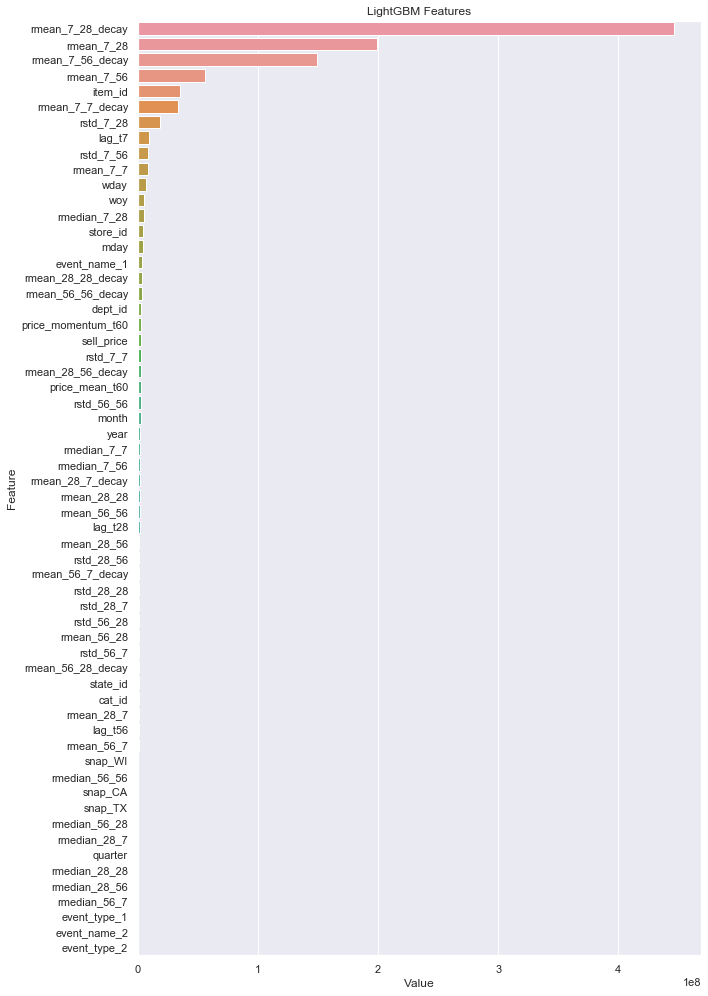

In [23]:
feature_importance = pd.DataFrame({"Value": m_lgb.feature_importance("gain"), "Feature": m_lgb.feature_name()}) \
                    .sort_values(by="Value", ascending=False)

# Change size of the plot, so we can see all features
fig_dims = (10, 14)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x="Value", y="Feature", ax=ax, data=feature_importance)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [24]:
# Detection of features with zero-importance
zero_features = list(feature_importance[feature_importance['Value'] == 0]['Feature'])
print('\nThere are {} features with 0.0 importance'.format(len(zero_features)))
print(zero_features)
feature_importance


There are 0 features with 0.0 importance
[]


,Value,Feature
34,4.466978e+08,rmean_7_28_decay
31,1.992646e+08,rmean_7_28
46,1.494828e+08,rmean_7_56_decay
43,5.601795e+07,rmean_7_56
0,3.558281e+07,item_id
22,3.336644e+07,rmean_7_7_decay
33,1.892817e+07,rstd_7_28
16,9.294417e+06,lag_t7
45,8.564251e+06,rstd_7_56
19,8.563938e+06,rmean_7_7


In [63]:
%%time 

tdata = pd.read_pickle(f'{DATA_GRID_INPUT_DIR}/m5_data_test_model2.pkl')

CPU times: user 195 ms, sys: 121 ms, total: 317 ms
Wall time: 321 ms


In [65]:
def create_lag_features_for_test(df, day):
    # create lag feaures just for single day (faster)
    lags = [7, 28, 56]
    lag_cols = [f"lag_t{lag}" for lag in lags]
    for lag, lag_col in zip(lags, lag_cols):
        df.loc[df.date == day, lag_col] = df.loc[df.date ==day-timedelta(days=lag), 'sales'].values  # !!! main

    wins = [7, 28, 56]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df_win = df[(df.date <= day-timedelta(days=lag)) & (df.date > day-timedelta(days=lag+win))]
            df_win_grouped_mean = df_win.groupby("id").agg({'sales':'mean'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmean_{lag}_{win}"] = df_win_grouped_mean.sales.values
            df_win_grouped_median = df_win.groupby("id").agg({'sales':'median'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rmedian_{lag}_{win}"] = df_win_grouped_median.sales.values
            df_win_grouped_std = df_win.groupby("id").agg({'sales':'std'}).reindex(df.loc[df.date==day,'id'])
            df.loc[df.date == day,f"rstd_{lag}_{win}"] = df_win_grouped_std.sales.values

            df[f'rmean_{lag}_{win}_decay'] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x: x.ewm(span=win).mean()).astype(np.float16)
#             df[f"rmedian_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).median()).astype(np.float16)
#             df[f"rstd_{lag}_{win}"] = df[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).std()).astype(np.float16)
            

    
    
## Creating features for test data
def create_static_features_for_test(df):
    # We create lags here, so we can use them later 
    # for weighted moving average computations
    lags = [7, 28, 56]
    lag_cols = [f"lag_t{lag}" for lag in lags ]

    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["id","sales"]].groupby("id")["sales"].shift(lag).astype(np.float16)
    
    # copy of the code from `create_df()` above
    date_features = {
        "wday": "weekday",
        "woy": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
    }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in df.columns:
            df[date_feat_name] = df[date_feat_name].astype("int16")
        else:
            df[date_feat_name] = getattr(
                df["date"].dt, date_feat_func).astype("int16")
            
    # Create price features
    df['price_mean_t60'] = df[['id','sell_price']].groupby(["id"])["sell_price"].transform(lambda x: x.rolling(60).mean()).astype(np.float16)
    df['price_momentum_t60'] = (df['sell_price'] / df['price_mean_t60']).astype(np.float16)
    
    # Add mean encoding features
#     global mean_encodings_df
#     df = df.merge(mean_encodings_df, on=['id'])

    return df


In [66]:
tdata = create_static_features_for_test(tdata)

In [48]:
# # FOR TEST
# day = FIRST_PRED_DAY + timedelta(days=0)
# print(i, day)
# tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
# create_lag_features_for_test(tst, day)
# tst = tst.loc[tst.date == day, train_cols]


27 2016-04-25 00:00:00


In [49]:
# os.system("say 'Task complete'")

0

In [61]:
# tst[tst.isna().any(axis=1)].shape[0] > 0

False

In [67]:
%%time

for i in range(0, 28):
    day = FIRST_PRED_DAY + timedelta(days=i)
    print(i, day)
    tst = tdata[(tdata.date >= day - timedelta(days=max_lags)) & (tdata.date <= day)].copy()
    create_lag_features_for_test(tst, day)
    tst = tst.loc[tst.date == day, train_cols]
    if tst[tst.isna().any(axis=1)].shape[0] > 0:
        print('Some values in tst are nans:')
        print(tst[tst.isna().any(axis=1)])
    tdata.loc[tdata.date == day, "sales"] = 1.03*m_lgb.predict(tst) 


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
CPU times: user 2h 6min 55s, sys: 2min 33s, total: 2h 9min 29s
Wall time: 1h 22min 28s


In [68]:
os.system('say "Prediction complete"')

0

In [69]:
tdata.loc[(tdata.date >= FIRST_PRED_DAY) & (tdata.sales > 2)].count()

id                    146664
item_id               146664
dept_id               146664
store_id              146664
cat_id                146664
state_id              146664
d                     146664
sales                 146664
date                  146664
wm_yr_wk              146664
weekday               146664
wday                  146664
month                 146664
year                  146664
event_name_1          146664
event_type_1          146664
event_name_2          146664
event_type_2          146664
snap_CA               146664
snap_TX               146664
snap_WI               146664
sell_price            146664
lag_t7                 34027
lag_t28               146664
lag_t56               146664
woy                   146664
quarter               146664
mday                  146664
price_mean_t60        146664
price_momentum_t60    146664
dtype: int64

In [70]:
%%time

tdata_sub = tdata.loc[tdata.date >= FIRST_PRED_DAY, ["id", "sales"]].copy()
tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+ timedelta(days=h), "id"] = tdata_sub.loc[tdata.date >= FIRST_PRED_DAY+timedelta(days=h), 
                                                                     "id"].str.replace("validation$", "evaluation")
tdata_sub["F"] = [f"F{rank}" for rank in tdata_sub.groupby("id")["id"].cumcount()+1]
tdata_sub = tdata_sub.set_index(["id", "F" ]).unstack()["sales"][[f"F{i}" for i in range(1,29)]].reset_index()
tdata_sub.fillna(0., inplace = True)

# kyakovlev magic trick
# for i in range(1,29):
#     tdata_sub['F'+str(i)] *= 1.03

tdata_sub.to_csv("submission.csv",index=False)
tdata_sub.shape


CPU times: user 3.65 s, sys: 188 ms, total: 3.84 s
Wall time: 3.86 s


(60980, 29)

In [71]:
tst

,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_t7,lag_t28,lag_t56,rmean_7_7,rmedian_7_7,rstd_7_7,rmean_7_7_decay,rmean_28_7,rmedian_28_7,rstd_28_7,rmean_28_7_decay,rmean_56_7,rmedian_56_7,rstd_56_7,rmean_56_7_decay,rmean_7_28,rmedian_7_28,rstd_7_28,rmean_7_28_decay,rmean_28_28,rmedian_28_28,rstd_28_28,rmean_28_28_decay,rmean_56_28,rmedian_56_28,rstd_56_28,rmean_56_28_decay,rmean_7_56,rmedian_7_56,rstd_7_56,rmean_7_56_decay,rmean_28_56,rmedian_28_56,rstd_28_56,rmean_28_56_decay,rmean_56_56,rmedian_56_56,rstd_56_56,rmean_56_56_decay,price_mean_t60,price_momentum_t60,woy,quarter,mday
4481422,0,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,8.382812,1.211914,1.0,1.0,1.000977,0.899902,0.169800,1.210938,1.142578,1.0,0.899902,1.070312,1.142578,1.0,0.689941,1.125977,1.017578,0.952148,0.451416,1.091797,0.964355,1.0,1.137695,1.054688,1.000000,1.0,0.942871,1.130859,0.991211,1.000000,0.836914,1.040039,0.981934,1.0,1.035156,1.026367,1.017578,1.0,1.103516,1.052734,8.351562,1.003906,20,2,22
4481429,1,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.970703,0.257324,0.0,1.0,0.198364,0.180298,0.041016,0.255615,0.142822,0.0,0.377930,0.079407,0.571289,1.0,0.534668,0.690430,0.188477,0.188232,0.185059,0.145142,0.071411,0.0,0.262207,0.110474,0.321533,0.0,0.475586,0.360107,0.183594,0.000000,0.302490,0.154907,0.196411,0.0,0.400879,0.147217,0.250000,0.0,0.437012,0.286133,3.970703,1.000000,20,2,22
4481436,2,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.970703,0.750488,1.0,0.0,0.516113,0.407959,0.156982,0.751953,0.856934,1.0,0.377930,0.931641,0.285645,0.0,0.487793,0.360840,0.589844,0.515625,0.269287,0.728516,0.571289,0.0,0.689941,0.721680,0.535645,0.0,1.201172,0.396973,0.509277,0.404297,0.525391,0.595703,0.553711,0.0,0.970703,0.583008,0.428467,0.0,0.911621,0.409180,2.970703,1.000000,20,2,22
4481443,3,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,4.640625,2.912109,2.0,6.0,2.019531,1.829102,0.544922,2.912109,2.572266,2.0,2.369141,2.855469,3.572266,4.0,2.369141,3.876953,2.136719,1.822266,1.239258,2.382812,1.821289,1.0,1.886719,2.218750,1.892578,1.0,1.968750,2.486328,2.103516,1.822266,1.669922,2.146484,1.857422,1.0,1.911133,2.078125,2.017578,1.5,1.892578,2.205078,4.640625,1.000000,20,2,22
4481450,4,0,0,0,0,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.880859,1.504883,4.0,0.0,1.190430,1.072266,0.265869,1.510742,1.713867,2.0,1.253906,2.154297,0.856934,0.0,1.214844,0.570312,1.282227,1.050781,0.675781,1.440430,1.357422,1.0,1.283203,1.419922,1.107422,1.0,0.994141,1.057617,1.212891,1.000000,1.008789,1.302734,1.232422,1.0,1.143555,1.279297,1.125000,1.0,1.176758,1.064453,2.880859,1.000000,20,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4694817,3044,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.980469,0.678711,1.0,0.0,0.509277,0.492432,0.092102,0.676270,0.285645,0.0,0.487793,0.404785,0.000000,0.0,0.000000,0.004211,0.420898,0.454102,0.262451,0.371094,0.214233,0.0,0.567871,0.276123,0.250000,0.0,0.585449,0.181030,0.281738,0.000000,0.434082,0.307861,0.232178,0.0,0.571777,0.288574,0.500000,0.0,0.914551,0.347412,2.980469,1.000000,20,2,22
4694824,3045,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,2.480469,0.400391,0.0,0.0,0.341553,0.346924,0.045593,0.398682,0.142822,0.0,0.377930,0.211792,0.000000,0.0,0.000000,0.000000,0.277344,0.304688,0.198853,0.272217,0.321533,0.0,0.547852,0.232422,0.000000,0.0,0.000000,0.000000,0.281494,0.247559,0.399658,0.207642,0.160767,0.0,0.416748,0.190063,0.000000,0.0,0.000000,0.000000,2.408203,1.030273,20,2,22
4694831,3046,6,9,2,2,2,5,2016,0,0,0,0,0.0,0.0,0.0,3.980469,1.546875,0.0,1.0,1.291016,1.211914,0.213135,1.537109,0.571289,0.0,0.786621,0.467285,0.714355,0.0,0.951172,0.732422,0.938477,1.000000,0.503418,0.992188,0.893066,0.5,1.165039,0.820312,1.250000,1.0,0.928223,0.957031,0.933594,1.000000,0.901855,0.941406,1